In [32]:
# %pip install -r requirements.txt

In [33]:
import os
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from pymongo import MongoClient
import certifi
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv, find_dotenv

In [34]:
print("Starting model training...")

dotenv_path = find_dotenv()
if dotenv_path:
    load_dotenv(dotenv_path)
else:
    print("No .env file found, skipping load_dotenv()")

MONGO_URI = os.getenv('CONNECTION_STRING')
if not MONGO_URI:
    raise ValueError("MONGO_URI environment variable not set!")
else:
    print("Correct code")

Starting model training...
Correct code


In [35]:
try:
    client = MongoClient(MONGO_URI, tlsCAFile=certifi.where())
    # The ping command is a simple way to verify a successful connection
    client.admin.command('ping')
    print("Successfully connected to MongoDB!")
except Exception as e:
    print(f"Error connecting to MongoDB: {e}")
    client = None # Set client to None if connection fails


Successfully connected to MongoDB!


In [36]:
# Connect to the database
# areas
# businesses
# ftpservers
# records
# users
# vehicles

In [37]:
db = client['car_parking'] 
collection = db['records'] 

In [38]:

print(f"Connecting to database '{db.name}' and collection '{collection.name}'...")
# Fetch all records and load them into a pandas DataFrame
cursor = collection.find({})
df = pd.DataFrame(list(cursor))


Connecting to database 'car_parking' and collection 'records'...


In [39]:
display(df)

,_id,areaId,datetime,plateNumber,country,confidence,angle,image,status,duration,__v
0,68b688b578d06fa1df4ed502,68463ea062d56405aaef9ffa,2025-09-02 05:41:09,LBJ196,AUS,95,13,2025-09-02_15-41-09_LBJ196.jpg,APPROACHING,0,0
1,68b688b578d06fa1df4ed50c,68463ea062d56405aaef9ffa,2025-09-02 05:41:19,TMZ110,AUS,86,272,2025-09-02_15-41-19_TMZ110.jpg,APPROACHING,0,0
2,68b688b578d06fa1df4ed516,68463ea062d56405aaef9ffa,2025-09-02 05:41:50,VEB090,AUS,87,287,2025-09-02_15-41-50_VEB090.jpg,APPROACHING,0,0
3,68b688b578d06fa1df4ed520,68463ea062d56405aaef9ffa,2025-09-02 06:03:30,WQP704,AUS,97,229,2025-09-02_16-03-30_WQP704.jpg,APPROACHING,0,0
4,68b688bb78d06fa1df4ed52a,68463ea062d56405aaef9ffc,2025-09-02 06:03:36,HEU475,AUS,83,58,2025-09-02_16-03-36_HEU475.jpg,APPROACHING,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1889,68ba67ebd6c276974a973430,68463ea062d56405aaef9ff9,2025-09-05 04:32:41,UEN149,AUS,89,281,2025-09-05_14-32-41_UEN149.jpg,APPROACHING,0,0
1890,68ba67f2d6c276974a97343a,68463ea062d56405aaef9ff9,2025-09-05 04:32:41,UEN149,AUS,89,281,2025-09-05_14-32-41_UEN149.jpg,APPROACHING,0,0
1891,68ba67f2d6c276974a973444,68463ea062d56405aaef9ff9,2025-09-05 04:32:46,ABU139,AUS,88,34,2025-09-05_14-32-46_ABU139.jpg,LEAVING,0,0
1892,68ba67f5d6c276974a973452,68463ea062d56405aaef9ff9,2025-09-05 04:32:46,ABU139,AUS,88,34,2025-09-05_14-32-46_ABU139.jpg,LEAVING,0,0


PREPROCESSING DATA FOR MODEL

In [40]:
def filter_plate_numbers(df):
    """
    Filters a DataFrame to select unique plate numbers, with a special condition
    for plates that are very similar and appear within a 2-minute window.

    Args:
        df (pd.DataFrame): The input DataFrame with at least 'datetime',
                           'plateNumber', and 'confidence' columns.

    Returns:
        pd.DataFrame: A new DataFrame with the filtered data.
    """
    # Ensure 'datetime' is in datetime format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Sort by datetime to easily compare consecutive records
    df = df.sort_values(by='datetime').reset_index(drop=True)

    # Use a set to keep track of indices to drop for efficiency
    to_drop = set()

    # Helper function to check for 5/6 similarity
    def are_plates_similar(plate1, plate2):
        if len(plate1) < 6 or len(plate2) < 6 or len(plate1) != len(plate2):
            return False
        # Count matching characters
        matching_chars = sum(1 for c1, c2 in zip(plate1, plate2) if c1 == c2)
        return matching_chars >= 5

    # Iterate through the DataFrame to find similar plates within the time window
    for i in range(len(df)):
        if i in to_drop:
            continue
        for j in range(i + 1, len(df)):
            if j in to_drop:
                continue

            time_diff_minutes = (df.loc[j, 'datetime'] - df.loc[i, 'datetime']).total_seconds() / 60

            # If the next record is more than 2 minutes away, break the inner loop
            if time_diff_minutes > 2:
                break

            plate1 = df.loc[i, 'plateNumber']
            plate2 = df.loc[j, 'plateNumber']

            # If plates are identical or similar, decide which one to drop based on confidence
            if plate1 == plate2 or are_plates_similar(plate1, plate2):
                if df.loc[i, 'confidence'] < df.loc[j, 'confidence']:
                    to_drop.add(i)
                    # Once 'i' is marked to be dropped, we can stop checking against it
                    break
                else:
                    to_drop.add(j)

    # Drop the identified rows for the time-based similarity condition
    df_filtered = df.drop(list(to_drop))

    # For the final "unique plateNumber only" rule, sort by confidence and drop duplicates
    df_final = df_filtered.sort_values('confidence', ascending=False)
    df_final = df_final.drop_duplicates(subset=['plateNumber'], keep='first')

    # Sort back by datetime for final presentation
    df_final = df_final.sort_values(by='datetime').reset_index(drop=True)

    return df_final

In [41]:
filtered_df = filter_plate_numbers(df)

In [42]:
display(filtered_df)

,_id,areaId,datetime,plateNumber,country,confidence,angle,image,status,duration,__v
0,68b688ed78d06fa1df4ed570,68463ea062d56405aaef9ff8,2025-09-02 05:42:00,TCQ359,AUS,90,60,2025-09-02_15-42-00_TCQ359.jpg,APPROACHING,0,0
1,68b688b578d06fa1df4ed520,68463ea062d56405aaef9ffa,2025-09-02 06:03:30,WQP704,AUS,97,229,2025-09-02_16-03-30_WQP704.jpg,APPROACHING,0,0
2,68b688c078d06fa1df4ed534,68463ea062d56405aaef9ff9,2025-09-02 06:03:41,OAA997,AUS,97,161,2025-09-02_16-03-41_OAA997.jpg,APPROACHING,0,0
3,68b6892b78d06fa1df4ed618,68463ea062d56405aaef9ff9,2025-09-02 06:05:29,EZS718,AUS,98,163,2025-09-02_16-05-29_EZS718.jpg,APPROACHING,0,0
4,68b6893f78d06fa1df4ed659,68463ea062d56405aaef9ffb,2025-09-02 06:05:49,YQC666,AUS,98,100,2025-09-02_16-05-49_YQC666.jpg,APPROACHING,0,0
...,...,...,...,...,...,...,...,...,...,...,...
584,68ba6735d6c276974a9733f4,68463ea062d56405aaef9ff9,2025-09-05 04:29:38,XFK043,AUS,81,271,2025-09-05_14-29-38_XFK043.jpg,APPROACHING,0,0
585,68ba673ad6c276974a973408,68463ea062d56405aaef9ff9,2025-09-05 04:29:43,WHW108,AUS,82,37,2025-09-05_14-29-43_WHW108.jpg,APPROACHING,0,0
586,68ba67e5d6c276974a97341c,68463ea062d56405aaef9ff9,2025-09-05 04:32:28,GVN789,AUS,80,210,2025-09-05_14-32-28_GVN789.jpg,APPROACHING,0,0
587,68ba67ebd6c276974a973430,68463ea062d56405aaef9ff9,2025-09-05 04:32:41,UEN149,AUS,89,281,2025-09-05_14-32-41_UEN149.jpg,APPROACHING,0,0


In [43]:
filtered_df.describe()

,datetime,confidence,angle,duration,__v
count,589,589.000000,589.000000,589.0,589.0
mean,2025-09-04 18:33:27.925297152,92.149406,181.516129,0.0,0.0
min,2025-09-02 05:42:00,80.000000,0.000000,0.0,0.0
25%,2025-09-05 00:23:18,88.000000,84.000000,0.0,0.0
50%,2025-09-05 00:48:25,93.000000,181.000000,0.0,0.0
75%,2025-09-05 01:14:59,97.000000,275.000000,0.0,0.0
max,2025-09-05 04:32:51,100.000000,359.000000,0.0,0.0
std,NaN,5.537266,107.359076,0.0,0.0


In [44]:
df = filtered_df

In [45]:
print(f"Successfully process {len(df)} records from MongoDB.")


Successfully process 589 records from MongoDB.


In [46]:
# Set the datetime column as the index
df.set_index('datetime', inplace=True)

# Resample the data to get the count of entries for each hour
hourly_entries = df.resample('H').size().rename('entries')

/var/folders/04/5xm3b6sx2t37x1hynkd6cbjw0000gp/T/ipykernel_46442/3797271727.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_entries = df.resample('H').size().rename('entries')


In [47]:
# Assuming 'hourly_entries' is your new DataFrame
df_model = hourly_entries.to_frame()
df_model['hour'] = df_model.index.hour
df_model['day_of_week'] = df_model.index.dayofweek # Monday=0, Sunday=6
df_model['day_of_month'] = df_model.index.day
df_model['month'] = df_model.index.month

In [48]:
display(df_model)

,entries,hour,day_of_week,day_of_month,month
datetime,,,,,
2025-09-02 05:00:00,1,5,1,2,9
2025-09-02 06:00:00,17,6,1,2,9
2025-09-02 07:00:00,0,7,1,2,9
2025-09-02 08:00:00,0,8,1,2,9
2025-09-02 09:00:00,0,9,1,2,9
...,...,...,...,...,...
2025-09-05 00:00:00,298,0,4,5,9
2025-09-05 01:00:00,93,1,4,5,9
2025-09-05 02:00:00,0,2,4,5,9


GENERATE DUMMY DATA + JOINING BOTH TABLE

In [49]:
def generate_sydney_parking_data(rows=10000):
    """
    Generates a DataFrame with simulated hourly parking entry data
    reflecting typical trends in Sydney.

    Args:
        rows (int): The number of data rows to generate.

    Returns:
        pandas.DataFrame: A DataFrame with the simulated parking data.
    """
    # Create a date range with hourly frequency
    # 10000 hours is approximately 1 year and 2 months
    date_rng = pd.date_range(start='2024-07-01', periods=rows, freq='H')

    # Create the initial DataFrame
    df = pd.DataFrame(date_rng, columns=['timestamp'])
    df.set_index('timestamp', inplace=True)

    # --- Feature Engineering ---
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # Monday=0, Sunday=6
    df['day_of_month'] = df.index.day
    df['month'] = df.index.month

    # --- Simulate Parking Trends ---

    # Define weights to simulate realistic trends
    # Busiest days: Thursday (late night shopping), Friday, and weekends
    day_of_week_weights = {
        0: 1.0,  # Monday
        1: 1.0,  # Tuesday
        2: 1.1,  # Wednesday
        3: 1.5,  # Thursday
        4: 1.6,  # Friday
        5: 1.8,  # Saturday
        6: 1.6   # Sunday
    }

    # Busiest months: Summer/Christmas period (Dec, Jan)
    month_weights = {
        1: 1.4, 2: 1.2, 3: 1.0, 4: 1.1, 5: 0.9, 6: 0.8,
        7: 0.8, 8: 0.9, 9: 1.0, 10: 1.1, 11: 1.2, 12: 1.5
    }

    def calculate_entries(row):
        """
        Calculates the number of parking entries based on time features.
        """
        # Start with a base level of entries + some randomness
        base_entries = np.random.randint(20, 40)

        # Apply day of the week multiplier
        day_multiplier = day_of_week_weights.get(row['day_of_week'], 1.0)

        # Apply month multiplier
        month_multiplier = month_weights.get(row['month'], 1.0)

        # Apply hour of the day multiplier (different for weekdays vs. weekends)
        hour = row['hour']
        is_weekend = row['day_of_week'] >= 5 # Saturday or Sunday

        if is_weekend:
            if 0 <= hour < 8:
                hour_multiplier = 0.4
            elif 8 <= hour < 11:
                hour_multiplier = 1.0
            elif 11 <= hour < 18:
                hour_multiplier = 1.8 # Peak shopping/leisure time
            elif 18 <= hour < 22:
                hour_multiplier = 1.5 # Evening/dinner time
            else:
                hour_multiplier = 0.9
        else: # Weekday
            if 0 <= hour < 6:
                hour_multiplier = 0.2 # Very low overnight
            elif 6 <= hour < 9:
                hour_multiplier = 1.1 # Morning commute
            elif 9 <= hour < 16:
                hour_multiplier = 1.4 # Business hours
            elif 16 <= hour < 19:
                hour_multiplier = 1.6 # Evening commute / shopping
            elif 19 <= hour < 22 and row['day_of_week'] == 3:
                 hour_multiplier = 1.8 # Thursday late night shopping peak
            else:
                hour_multiplier = 0.7

        # Calculate final entries
        entries = base_entries * day_multiplier * month_multiplier * hour_multiplier

        # Add some final random noise to make it more realistic
        final_entries = entries + np.random.randint(-15, 15)

        # Ensure entries are not negative
        return max(0, int(final_entries))

    # Apply the function to create the 'entries' column
    df['entries'] = df.apply(calculate_entries, axis=1)

    # Reorder columns to have 'entries' first, like the original example
    df = df[['entries', 'hour', 'day_of_week', 'day_of_month', 'month']]

    return df


In [50]:
df_dummy = generate_sydney_parking_data(rows=10000)

/var/folders/04/5xm3b6sx2t37x1hynkd6cbjw0000gp/T/ipykernel_46442/2314714160.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2024-07-01', periods=rows, freq='H')


In [51]:
display(df_dummy)

,entries,hour,day_of_week,day_of_month,month
timestamp,,,,,
2024-07-01 00:00:00,0,0,0,1,7
2024-07-01 01:00:00,0,1,0,1,7
2024-07-01 02:00:00,11,2,0,1,7
2024-07-01 03:00:00,0,3,0,1,7
2024-07-01 04:00:00,18,4,0,1,7
...,...,...,...,...,...
2025-08-21 11:00:00,49,11,3,21,8
2025-08-21 12:00:00,66,12,3,21,8
2025-08-21 13:00:00,84,13,3,21,8


In [52]:
df_dummy.index.name = 'datetime'
ml_df = pd.concat([df_dummy, df_model], axis=0).sort_index()

In [53]:
display(ml_df)

,entries,hour,day_of_week,day_of_month,month
datetime,,,,,
2024-07-01 00:00:00,0,0,0,1,7
2024-07-01 01:00:00,0,1,0,1,7
2024-07-01 02:00:00,11,2,0,1,7
2024-07-01 03:00:00,0,3,0,1,7
2024-07-01 04:00:00,18,4,0,1,7
...,...,...,...,...,...
2025-09-05 00:00:00,298,0,4,5,9
2025-09-05 01:00:00,93,1,4,5,9
2025-09-05 02:00:00,0,2,4,5,9


In [58]:
# Split the data at a certain point in time
split_date = '2025-06-10'
train_data = ml_df.loc[ml_df.index <= split_date]
test_data = ml_df.loc[ml_df.index > split_date]

In [59]:
# Example using an XGBoost model
import xgboost as xgb

# Define features (X) and target (y)
FEATURES = ['hour', 'day_of_week', 'day_of_month', 'month']
TARGET = 'entries'

# Create the model
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)

# Fit the model to the training data
model.fit(train_data[FEATURES], train_data[TARGET])

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [60]:
test_predictions = model.predict(test_data[FEATURES])

In [61]:
test_data['predictions'] = test_predictions

/var/folders/04/5xm3b6sx2t37x1hynkd6cbjw0000gp/T/ipykernel_46442/2110674450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predictions'] = test_predictions


Mean Absolute Error (MAE): 10.65
This means, on average, the model's prediction is off by about 10.65 vehicles per hour.
Root Mean Squared Error (RMSE): 15.83


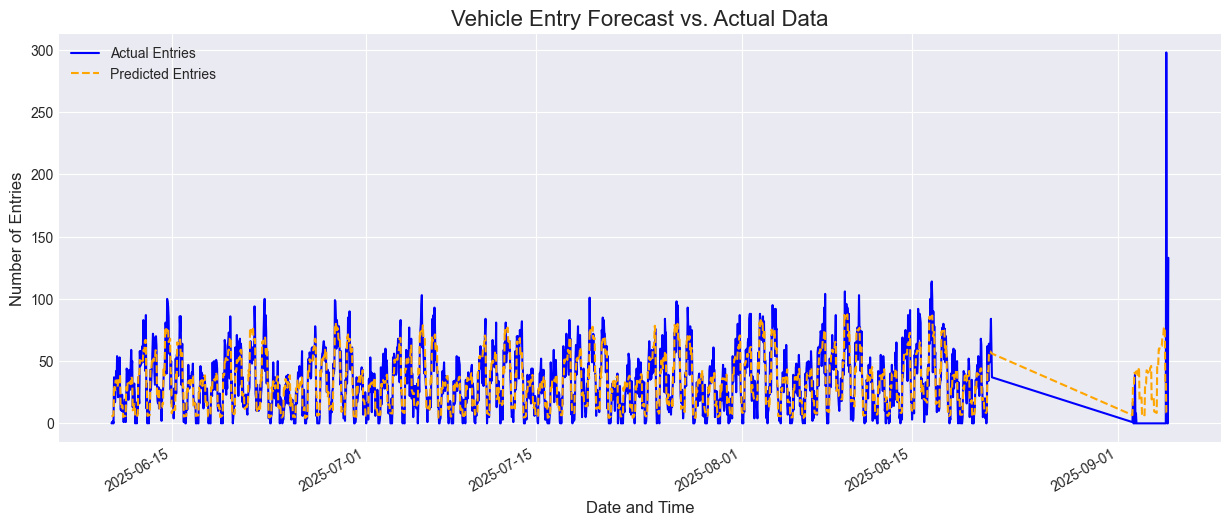

In [62]:
actuals = test_data[TARGET]
predictions = test_data['predictions']

# Mean Absolute Error (MAE) - The average absolute difference between prediction and actual
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"This means, on average, the model's prediction is off by about {mae:.2f} vehicles per hour.")

# Root Mean Squared Error (RMSE) - Punishes larger errors more heavily
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


# --- Step 3: Visualize the Results ---
# Plotting the actual values vs. the predicted values is the best way to see performance.

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(15, 6))

# Plot actuals and predictions
test_data[TARGET].plot(ax=ax, label='Actual Entries', color='blue')
test_data['predictions'].plot(ax=ax, label='Predicted Entries', color='orange', linestyle='--')

# Formatting the plot
ax.set_title('Vehicle Entry Forecast vs. Actual Data', fontsize=16)
ax.set_xlabel('Date and Time', fontsize=12)
ax.set_ylabel('Number of Entries', fontsize=12)
ax.legend()
plt.show()

In [63]:
# For XGBoost
model.save_model("vehicle_forecaster.json")

# For scikit-learn or other models using joblib
import joblib
joblib.dump(model, "vehicle_forecaster.joblib")

['vehicle_forecaster.joblib']